In [2]:
from scipy.odr import polynomial
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC, LinearSVC
from sklearn.datasets import load_iris
import numpy as np
from sklearn.pipeline import Pipeline
from xgboost.testing import datasets

iris = load_iris()
X= iris.data[:, [2, 3]]
y = (iris.target==2).astype(np.float64)

svm_clf = Pipeline([
    ("scaler", StandardScaler()),
    ("linear_svc",LinearSVC(C=1, loss="hinge"))
])

svm_clf.fit(X, y)

,steps,"[('scaler', ...), ('linear_svc', ...)]"
,transform_input,None
,memory,None
,verbose,False
,copy,True
,with_mean,True
,with_std,True
,penalty,'l2'
,loss,'hinge'
,dual,'auto'
,tol,0.0001


In [3]:
svm_clf.predict([[5.5, 1.7]])

array([1.])

In [4]:
from sklearn import datasets
from sklearn.preprocessing import PolynomialFeatures

X,y = datasets.make_moons(n_samples=100, noise=0.20)
polynomial_svm_clf = Pipeline([
    ("poly_features", PolynomialFeatures(degree=3)),
    ("scaler", StandardScaler()),
    ("svm_clf", LinearSVC(C=10, loss="hinge"))
])

polynomial_svm_clf.fit(X, y)

/opt/anaconda3/envs/ml/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


,steps,"[('poly_features', ...), ('scaler', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,degree,3
,interaction_only,False
,include_bias,True
,order,'C'
,copy,True
,with_mean,True
,with_std,True


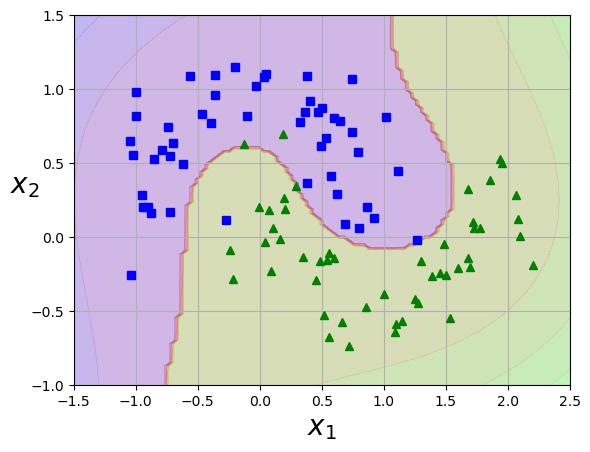

In [5]:
import matplotlib.pyplot as plt

def plot_dataset(X, y, axes):
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "bs")
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "g^")
    plt.axis(axes)
    plt.grid(True, which='both')
    plt.xlabel(r"$x_1$", fontsize=20)
    plt.ylabel(r"$x_2$", fontsize=20, rotation=0)

def plot_predictions(clf, axes):
    x0s = np.linspace(axes[0], axes[1], 100)
    x1s = np.linspace(axes[2], axes[3], 100)
    x0, x1 = np.meshgrid(x0s, x1s)
    X = np.c_[x0.ravel(), x1.ravel()]
    y_pred = clf.predict(X).reshape(x0.shape)
    y_decision = clf.decision_function(X).reshape(x0.shape)
    plt.contourf(x0, x1, y_pred, cmap=plt.cm.brg, alpha=0.2)
    plt.contourf(x0, x1, y_decision, cmap=plt.cm.brg, alpha=0.1)

plot_predictions(polynomial_svm_clf, [-1.5, 2.5, -1, 1.5])
plot_dataset(X, y, [-1.5, 2.5, -1, 1.5])



In [6]:
rbf_kernel_svm_clf = Pipeline([
("scaler", StandardScaler()),
("svm_clf", SVC(kernel="rbf", gamma=5, C=0.001))
])
rbf_kernel_svm_clf.fit(X, y)

,steps,"[('scaler', ...), ('svm_clf', ...)]"
,transform_input,None
,memory,None
,verbose,False
,copy,True
,with_mean,True
,with_std,True
,C,0.001
,kernel,'rbf'
,degree,3
,gamma,5


In [7]:
X = iris["data"][:, (2, 3)] # petal length, petal width
y = (iris["target"] == 2).astype(np.float64).reshape(-1, 1)

In [12]:
from sklearn.base import BaseEstimator

class MyLinearSVC(BaseEstimator):
    def __init__(self,C = 1, eta0 = 1, eta_d = 1000, n_epochs = 1000):
        self.C = C
        self.eta0 = eta0
        self.eta_d = eta_d
        self.n_epochs = n_epochs
    def eta(self,epoch):
        return self.eta0/(epoch+self.eta_d)
    def fit(self,X,y):
        w = np.random.randn(X.shape[1], 1)
        b = 0

        m = len(X)
        t = y*2 -1
        self.Js = []
        X_t = X*t

        for epoch in range(self.n_epochs):
            support_vectors_idx = (X_t.dot(w) + t * b < 1).ravel()
            X_t_sv = X_t[support_vectors_idx]
            t_sv = t[support_vectors_idx]

            J = 1/2*np.sum(w*w) + self.C*np.sum(1-X_t_sv.dot(w)-b*np.sum(t_sv))
            self.Js.append(J)

            w_gradient_vector = w - self.C * np.sum(X_t_sv, axis=0).reshape(-1, 1)
            b_derivative = -self.C * np.sum(t_sv)

            w = w - self.eta(epoch) * w_gradient_vector
            b = b - self.eta(epoch) * b_derivative

        self.intercept_ = np.array([b])
        self.coef_ = np.array([w])
        support_vectors_idx = (X_t.dot(w) + t * b < 1).ravel()
        self.support_vectors_ = X[support_vectors_idx]
        return self
    def decision_function(self, X):
        return X.dot(self.coef_[0]) + self.intercept_[0]
    def predict(self, X):
        return (self.decision_function(X) >= 0).astype(np.float64)

C=2
svm_clf = MyLinearSVC(C=C, eta0 = 10, eta_d = 1000, n_epochs=60000)
svm_clf.fit(X, y)
svm_clf.predict(np.array([[5, 2], [4, 1]]))

array([[1.],
       [0.]])

In [17]:
print(svm_clf.intercept_, svm_clf.coef_)

[-15.56758242] [[[2.28112369]
  [2.71642663]]]


In [18]:
svm_clf2 = SVC(kernel="linear", C=C)
svm_clf2.fit(X, y.ravel())
print(svm_clf2.intercept_, svm_clf2.coef_)

[-15.51721253] [[2.27128546 2.71287145]]


Text(0.5, 1.0, 'SVC')

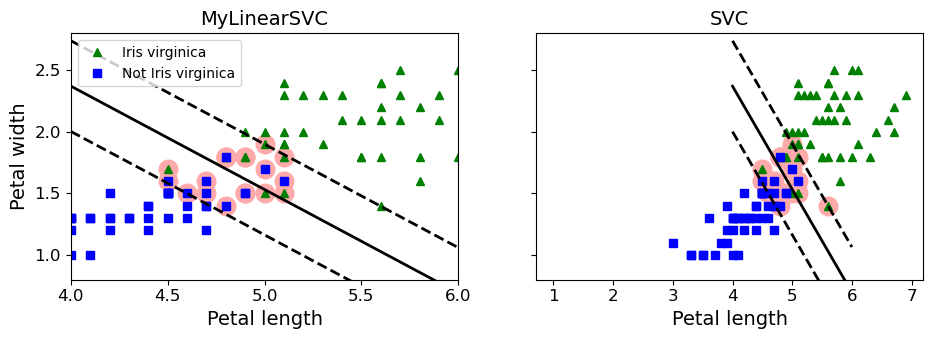

In [20]:

def plot_svc_decision_boundary(svm_clf, xmin, xmax):
    w = svm_clf.coef_[0]
    b = svm_clf.intercept_[0]

    # At the decision boundary, w0*x0 + w1*x1 + b = 0
    # => x1 = -w0/w1 * x0 - b/w1
    x0 = np.linspace(xmin, xmax, 200)
    decision_boundary = -w[0]/w[1] * x0 - b/w[1]

    margin = 1/w[1]
    gutter_up = decision_boundary + margin
    gutter_down = decision_boundary - margin

    svs = svm_clf.support_vectors_
    plt.scatter(svs[:, 0], svs[:, 1], s=180, facecolors='#FFAAAA')
    plt.plot(x0, decision_boundary, "k-", linewidth=2)
    plt.plot(x0, gutter_up, "k--", linewidth=2)
    plt.plot(x0, gutter_down, "k--", linewidth=2)

yr = y.ravel()
fig, axes = plt.subplots(ncols=2, figsize=(11, 3.2), sharey=True)
plt.sca(axes[0])
plt.plot(X[:, 0][yr==1], X[:, 1][yr==1], "g^", label="Iris virginica")
plt.plot(X[:, 0][yr==0], X[:, 1][yr==0], "bs", label="Not Iris virginica")
plot_svc_decision_boundary(svm_clf, 4, 6)
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.title("MyLinearSVC", fontsize=14)
plt.axis([4, 6, 0.8, 2.8])
plt.legend(loc="upper left")

plt.sca(axes[1])
plt.plot(X[:, 0][yr==1], X[:, 1][yr==1], "g^")
plt.plot(X[:, 0][yr==0], X[:, 1][yr==0], "bs")
plot_svc_decision_boundary(svm_clf2, 4, 6)
plt.xlabel("Petal length", fontsize=14)
plt.title("SVC", fontsize=14)

[-12.52988101   1.94162342   1.84544824]


(np.float64(4.0), np.float64(6.0), np.float64(0.8), np.float64(2.8))

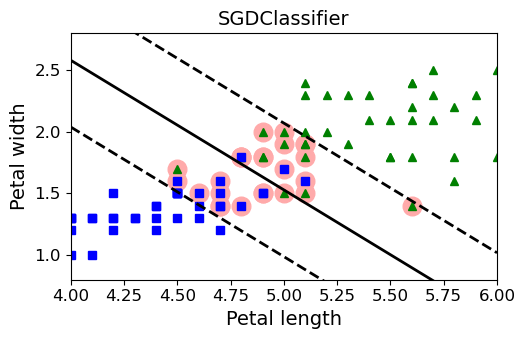

In [21]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(loss="hinge", alpha=0.017, max_iter=1000, tol=1e-3, random_state=42)
sgd_clf.fit(X, y.ravel())

m = len(X)
t = y * 2 - 1  # -1 if y==0, +1 if y==1
X_b = np.c_[np.ones((m, 1)), X]  # Add bias input x0=1
X_b_t = X_b * t
sgd_theta = np.r_[sgd_clf.intercept_[0], sgd_clf.coef_[0]]
print(sgd_theta)
support_vectors_idx = (X_b_t.dot(sgd_theta) < 1).ravel()
sgd_clf.support_vectors_ = X[support_vectors_idx]
sgd_clf.C = C

plt.figure(figsize=(5.5,3.2))
plt.plot(X[:, 0][yr==1], X[:, 1][yr==1], "g^")
plt.plot(X[:, 0][yr==0], X[:, 1][yr==0], "bs")
plot_svc_decision_boundary(sgd_clf, 4, 6)
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.title("SGDClassifier", fontsize=14)
plt.axis([4, 6, 0.8, 2.8])

In [22]:
from sklearn import datasets

iris = datasets.load_iris()
X = iris["data"][:, (2, 3)]  # petal length, petal width
y = iris["target"]

setosa_or_versicolor = (y == 0) | (y == 1)
X = X[setosa_or_versicolor]
y = y[setosa_or_versicolor]

In [23]:
from sklearn.svm import SVC, LinearSVC
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler

C = 5
alpha = 1 / (C * len(X))

lin_clf = LinearSVC(loss="hinge", C=C, random_state=42)
svm_clf = SVC(kernel="linear", C=C)
sgd_clf = SGDClassifier(loss="hinge", learning_rate="constant", eta0=0.001, alpha=alpha,
                        max_iter=1000, tol=1e-3, random_state=42)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

lin_clf.fit(X_scaled, y)
svm_clf.fit(X_scaled, y)
sgd_clf.fit(X_scaled, y)

print("LinearSVC:                   ", lin_clf.intercept_, lin_clf.coef_)
print("SVC:                         ", svm_clf.intercept_, svm_clf.coef_)
print("SGDClassifier(alpha={:.5f}):".format(sgd_clf.alpha), sgd_clf.intercept_, sgd_clf.coef_)

LinearSVC:                    [0.28475098] [[1.05364854 1.09903804]]
SVC:                          [0.31896852] [[1.1203284  1.02625193]]
SGDClassifier(alpha=0.00200): [0.117] [[0.77714169 0.72981762]]


(np.float64(0.0), np.float64(5.5), np.float64(0.0), np.float64(2.0))

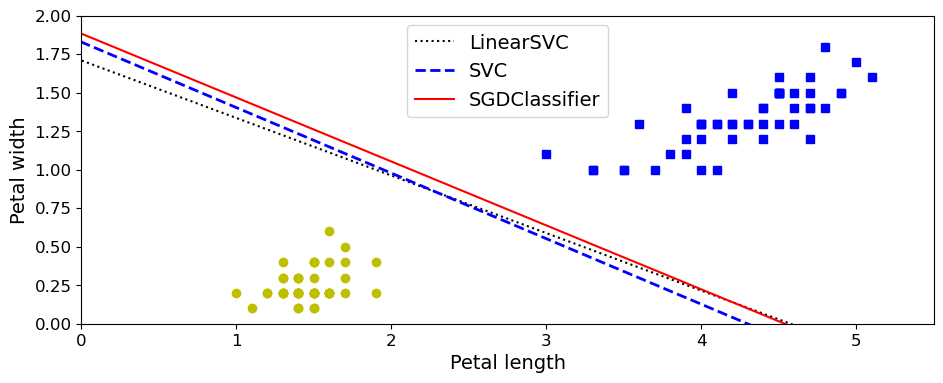

In [24]:
w1 = -lin_clf.coef_[0, 0]/lin_clf.coef_[0, 1]
b1 = -lin_clf.intercept_[0]/lin_clf.coef_[0, 1]
w2 = -svm_clf.coef_[0, 0]/svm_clf.coef_[0, 1]
b2 = -svm_clf.intercept_[0]/svm_clf.coef_[0, 1]
w3 = -sgd_clf.coef_[0, 0]/sgd_clf.coef_[0, 1]
b3 = -sgd_clf.intercept_[0]/sgd_clf.coef_[0, 1]

# Transform the decision boundary lines back to the original scale
line1 = scaler.inverse_transform([[-10, -10 * w1 + b1], [10, 10 * w1 + b1]])
line2 = scaler.inverse_transform([[-10, -10 * w2 + b2], [10, 10 * w2 + b2]])
line3 = scaler.inverse_transform([[-10, -10 * w3 + b3], [10, 10 * w3 + b3]])

# Plot all three decision boundaries
plt.figure(figsize=(11, 4))
plt.plot(line1[:, 0], line1[:, 1], "k:", label="LinearSVC")
plt.plot(line2[:, 0], line2[:, 1], "b--", linewidth=2, label="SVC")
plt.plot(line3[:, 0], line3[:, 1], "r-", label="SGDClassifier")
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs") # label="Iris versicolor"
plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo") # label="Iris setosa"
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.legend(loc="upper center", fontsize=14)
plt.axis([0, 5.5, 0, 2])

In [3]:
from sklearn import datasets
import numpy as np
mnist = datasets.fetch_openml('mnist_784', version=1, cache=True, as_frame=False)

X = mnist["data"]
y = mnist["target"].astype(np.uint8)

X_train = X[:60000]
y_train = y[:60000]
X_test = X[60000:]
y_test = y[60000:]

In [4]:
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC, LinearSVC


scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float32))
X_test_scaled = scaler.transform(X_test.astype(np.float32))

In [5]:
lin_clf = LinearSVC()
lin_clf.fit(X_train_scaled, y_train)

/opt/anaconda3/envs/ml/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


,penalty,'l2'
,loss,'squared_hinge'
,dual,'auto'
,tol,0.0001
,C,1.0
,multi_class,'ovr'
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,verbose,0
,random_state,None


In [6]:
from sklearn.metrics import accuracy_score

y_pred = lin_clf.predict(X_train_scaled)
accuracy_score(y_train, y_pred)

0.9274833333333333

In [7]:
svm_clf = SVC(gamma="scale")

In [9]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import reciprocal, uniform

param_distributions = {"gamma": reciprocal(0.001, 0.1), "C": uniform(1, 10)}
rnd_search_cv = RandomizedSearchCV(svm_clf, param_distributions, n_iter=10, verbose=2, cv=3,n_jobs=-1)
rnd_search_cv.fit(X_train_scaled[:1000], y_train[:1000])

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] END ..C=3.5999037443284267, gamma=0.0030034792051403373; total time=   0.2s
[CV] END ...C=9.397803835225831, gamma=0.0012225454083951263; total time=   0.2s
[CV] END ..C=3.5999037443284267, gamma=0.0030034792051403373; total time=   0.2s
[CV] END .....C=7.258357133334135, gamma=0.01737447635285429; total time=   0.3s
[CV] END .....C=5.428036168180249, gamma=0.02971767959482515; total time=   0.3s
[CV] END .....C=7.258357133334135, gamma=0.01737447635285429; total time=   0.3s
[CV] END ..C=3.5999037443284267, gamma=0.0030034792051403373; total time=   0.3s
[CV] END ...C=9.397803835225831, gamma=0.0012225454083951263; total time=   0.2s
[CV] END .....C=5.428036168180249, gamma=0.02971767959482515; total time=   0.3s
[CV] END .....C=5.428036168180249, gamma=0.02971767959482515; total time=   0.3s
[CV] END .....C=7.258357133334135, gamma=0.01737447635285429; total time=   0.3s
[CV] END ...C=4.819947108598763, gamma=0.0018230

,estimator,SVC()
,param_distributions,"{'C': <scipy.stats....t 0x157d05c90>, 'gamma': <scipy.stats....t 0x157d04190>}"
,n_iter,10
,scoring,None
,n_jobs,-1
,refit,True
,cv,3
,verbose,2
,pre_dispatch,'2*n_jobs'
,random_state,None
,error_score,nan


In [11]:
rnd_search_cv.best_estimator_

,C,np.float64(9.397803835225831)
,kernel,'rbf'
,degree,3
,gamma,np.float64(0....5454083951263)
,coef0,0.0
,shrinking,True
,probability,False
,tol,0.001
,cache_size,200
,class_weight,None
,verbose,False


In [12]:
rnd_search_cv.best_score_

np.float64(0.8609927292562024)

In [13]:
rnd_search_cv.best_estimator_.fit(X_train_scaled, y_train)

,C,np.float64(9.397803835225831)
,kernel,'rbf'
,degree,3
,gamma,np.float64(0....5454083951263)
,coef0,0.0
,shrinking,True
,probability,False
,tol,0.001
,cache_size,200
,class_weight,None
,verbose,False


In [14]:
y_pred = rnd_search_cv.best_estimator_.predict(X_train_scaled)
accuracy_score(y_train, y_pred)

0.999

In [15]:
y_pred = rnd_search_cv.best_estimator_.predict(X_test_scaled)
accuracy_score(y_test, y_pred)

0.9733

In [16]:
housing = datasets.fetch_california_housing()
X = housing["data"]
y = housing["target"]

In [17]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [18]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [19]:
from sklearn.svm import LinearSVR

lin_svr = LinearSVR()
lin_svr.fit(X_train_scaled, y_train)

/opt/anaconda3/envs/ml/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


,epsilon,0.0
,tol,0.0001
,C,1.0
,loss,'epsilon_insensitive'
,fit_intercept,True
,intercept_scaling,1.0
,dual,'auto'
,verbose,0
,random_state,None
,max_iter,1000


In [20]:
from sklearn.metrics import mean_squared_error

y_pred = lin_svr.predict(X_train_scaled)
mse = mean_squared_error(y_train, y_pred)
mse

1.4257532002547288

In [21]:
np.sqrt(mse)

np.float64(1.1940490778249984)

In [24]:
from sklearn.svm import SVR

param_distributions = {"gamma": reciprocal(0.001, 0.1), "C": uniform(1, 10)}
rnd_search_cv = RandomizedSearchCV(SVR(), param_distributions, n_iter=10, verbose=2, cv=3,n_jobs=-1)
rnd_search_cv.fit(X_train_scaled, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] END ...C=2.3413075104597216, gamma=0.021533927629312333; total time=   5.4s
[CV] END ...C=2.3413075104597216, gamma=0.021533927629312333; total time=   5.4s
[CV] END ....C=3.596854188756713, gamma=0.011275637058564771; total time=   5.2s
[CV] END ....C=5.702592375189249, gamma=0.008582858905689016; total time=   5.6s
[CV] END ....C=5.702592375189249, gamma=0.008582858905689016; total time=   5.5s
[CV] END ...C=2.3413075104597216, gamma=0.021533927629312333; total time=   5.6s
[CV] END ....C=5.702592375189249, gamma=0.008582858905689016; total time=   5.6s
[CV] END ....C=3.596854188756713, gamma=0.011275637058564771; total time=   5.6s
[CV] END ...C=10.696923916715445, gamma=0.023256606889951483; total time=   5.8s
[CV] END ...C=10.696923916715445, gamma=0.023256606889951483; total time=   6.0s
[CV] END ...C=10.696923916715445, gamma=0.023256606889951483; total time=   6.1s
[CV] END ...C=1.542848941162789, gamma=0.0023102

,estimator,SVR()
,param_distributions,"{'C': <scipy.stats....t 0x157397810>, 'gamma': <scipy.stats....t 0x1573961d0>}"
,n_iter,10
,scoring,None
,n_jobs,-1
,refit,True
,cv,3
,verbose,2
,pre_dispatch,'2*n_jobs'
,random_state,None
,error_score,nan


In [25]:
rnd_search_cv.best_estimator_

,kernel,'rbf'
,degree,3
,gamma,np.float64(0....1216753461749)
,coef0,0.0
,tol,0.001
,C,np.float64(6.5358790956967034)
,epsilon,0.1
,shrinking,True
,cache_size,200
,verbose,False
,max_iter,-1


In [26]:
y_pred = rnd_search_cv.best_estimator_.predict(X_train_scaled)
mse = mean_squared_error(y_train, y_pred)
np.sqrt(mse)

np.float64(0.6065329807003689)

In [27]:
y_pred = rnd_search_cv.best_estimator_.predict(X_test_scaled)
mse = mean_squared_error(y_test, y_pred)
np.sqrt(mse)

np.float64(0.5964503171742196)